<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainNumArmsClassifier_21_Spacy_Textcat_prefiltered_fewer_bins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
df_annotations = pd.read_csv("/content/drive/MyDrive/data/filtered_for_phase_arms_subjects.csv.bz2")

# Get data

In [5]:
df_annotations = df_annotations[~df_annotations.num_arms.isna()]

In [6]:
df_annotations["num_arms"].value_counts()

2.0     5228
1.0     3086
3.0     1456
4.0      908
5.0      315
6.0      251
7.0       83
8.0       80
9.0       58
10.0      31
12.0      27
11.0      17
13.0      10
14.0       8
15.0       7
18.0       5
16.0       4
20.0       3
17.0       3
23.0       2
21.0       2
29.0       1
19.0       1
34.0       1
38.0       1
30.0       1
40.0       1
22.0       1
Name: num_arms, dtype: int64

In [7]:
import numpy as np
for i in np.quantile(df_annotations["num_arms"], [0, 0.2, 0.4, 0.6, 0.8, 1]):
  print (int(np.float(i)))

1
1
2
2
3
40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
def get_num_arms_clean(num):
    if pd.isna(num):
        return None
    if num >= 3:
        return "3+"
    return str(int(num))
df_annotations["num_arms_clean"] = df_annotations["num_arms"].apply(get_num_arms_clean)

In [9]:
df_annotations["num_arms_clean"].value_counts()

2     5228
3+    3277
1     3086
Name: num_arms_clean, dtype: int64

In [10]:
labels = list(sorted(set(df_annotations["num_arms_clean"]), key =lambda x : int(re.sub(r'\D.*', '', x))))
labels

['1', '2', '3+']

In [ ]:
import spacy
nlp = spacy.blank("en")
from spacy.tokens import DocBin

docs_train = []
for i in range(10):
  docs_train.append(DocBin())
docs_val = DocBin()

for idx in range(len(df_annotations)):
  if idx % 100 == 0:
    print (idx, len(df_annotations))
  if df_annotations.train_val.iloc[idx] == "train":
    docs_list = docs_train[idx % 10]
  else:
    docs_list = docs_val
  text = str(df_annotations.text.iloc[idx])
  if len(text) > 100000:
      text = text[:100000]
  doc = nlp(text)

  cats = {}
  for a in labels:
      cats[a] = 0
  if pd.isna(df_annotations.num_arms_clean.iloc[idx]):
    continue
  cats[df_annotations.num_arms_clean.iloc[idx]] = 1
  doc.cats = cats

  docs_list.add(doc)

In [ ]:
!mkdir train.spacy
!mkdir /content/drive/MyDrive/data/arms_21_train.spacy


mkdir: cannot create directory ‘/content/drive/MyDrive/data/arms_21_train.spacy’: File exists


In [ ]:
for idx, doc_bin_train in enumerate(docs_train):
  doc_bin_train.to_disk(f"train.spacy/train_doc_bin{idx}.spacy")
  doc_bin_train.to_disk(f"/content/drive/MyDrive/data/arms_21_train.spacy/train_doc_bin{idx}.spacy")

In [ ]:
!ls /content/drive/MyDrive/data/arms_21_train.spacy

train_doc_bin0.spacy  train_doc_bin4.spacy  train_doc_bin8.spacy
train_doc_bin1.spacy  train_doc_bin5.spacy  train_doc_bin9.spacy
train_doc_bin2.spacy  train_doc_bin6.spacy
train_doc_bin3.spacy  train_doc_bin7.spacy


In [ ]:
docs_val.to_disk("dev.spacy")

In [ ]:
docs_val.to_disk("/content/drive/MyDrive/data/arms_21_dev.spacy")

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

In [ ]:
!python -m spacy train /content/drive/MyDrive/data/spacy_textcat_is_international_11.cfg --output /content/drive/MyDrive/data/output_arms_21 --paths.train /content/drive/MyDrive/data/arms_21_train.spacy --paths.dev  /content/drive/MyDrive/data/arms_21_dev.spacy --gpu-id 0

In [11]:
import spacy
nlp = spacy.load("/content/drive/MyDrive/data/output_arms_21/model-best")

In [12]:
df_val = df_annotations[df_annotations.train_val=="val"]

predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [13]:
# pred_proba = []
# for idx in range(len(df_val)):
#     pred_proba.append([predictions[idx][a] for a in range(num_classes)])

In [14]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.apply(str).iloc[idx])
    predictions.append(doc.cats)

In [15]:
df_val["y_pred"] = [max(p, key=p.get) for p in predictions]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
num_arms_ground_truths = df_val.num_arms_clean
pred_num_arms = df_val["y_pred"]

In [17]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.6732954545454546


''

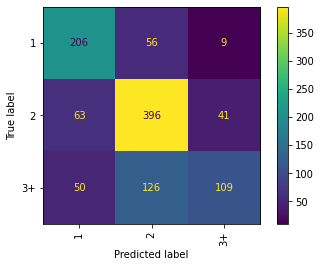

In [18]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms, labels=labels)
plt.xticks(rotation=90)
;

In [19]:
all_aucs = []
from sklearn.metrics import roc_auc_score
for i in labels:
  roc_auc = roc_auc_score(num_arms_ground_truths == i, [p[i] for p in predictions])
  print (f"Num arms ROC AUC {roc_auc} for {i} arms")
  all_aucs.append(roc_auc)
print ("Average", np.mean(all_aucs))

Num arms ROC AUC 0.8629210050062284 for 1 arms
Num arms ROC AUC 0.772158273381295 for 2 arms
Num arms ROC AUC 0.7071859285047898 for 3+ arms
Average 0.7807550689641044


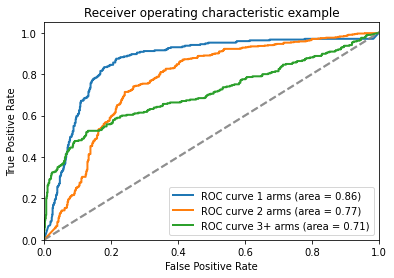

In [20]:
plt.figure()
lw = 2
    
for i in labels:
    fpr, tpr, _ = roc_curve(num_arms_ground_truths == i, [p[i] for p in predictions])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve {i} arms (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()